# Hypothesis Testing

This notebook is for Chapter 7 of [Think Stats - Probability and Statistics for Programmers](http://greenteapress.com/thinkstats/) by Allen B Downey.

Objective: learn techniques to decide if apparent effects are __significant__. An apparent effect is __statistically significant__ if it unlikely to have occurred by chance.

In [1]:
from __future__ import division, print_function
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
%matplotlib inline

## Testing Difference in Means

In the NSFG data, we saw that the mean pregnancy length for first babies is slightly longer, and the mean weight at birth is slightly smaller. Now we will see if those effects are significant.

    H0: distribution of the two groups (first and other babies) are same


    

In [2]:
pregnancies = pd.read_fwf("../data/2002FemPreg.dat", 
                         names=["caseid", "nbrnaliv", "babysex", "birthwgt_lb",
                               "birthwgt_oz", "prglength", "outcome", "birthord",
                               "agepreg", "finalwgt"],
                         colspecs=[(0, 12), (21, 22), (55, 56), (57, 58), (58, 60),
                                (274, 276), (276, 277), (278, 279), (283, 285), (422, 439)])
pregnancies.head()

,caseid,nbrnaliv,babysex,birthwgt_lb,birthwgt_oz,prglength,outcome,birthord,agepreg,finalwgt
0,1,1,1,8,13,39,1,1,33,6448.271112
1,1,1,2,7,14,39,1,2,39,6448.271112
2,2,3,1,9,2,39,1,1,14,12999.542264
3,2,1,2,7,0,39,1,2,17,12999.542264
4,2,1,2,6,3,39,1,3,18,12999.542264


In [3]:
# Look at the input data
live_births = pregnancies[pregnancies["outcome"] == 1]
first_babies = np.array(live_births[live_births["birthord"] == 1]["prglength"].dropna())
other_babies = np.array(live_births[live_births["birthord"] != 1]["prglength"].dropna())
print("# first babies: %d, other babies: %d" % (first_babies.shape[0], other_babies.shape[0]))
delta = np.mean(first_babies) - np.mean(other_babies)
print("Difference in means (data): %.3f weeks" % (delta))

# first babies: 4413, other babies: 4735
Difference in means (data): 0.078 weeks


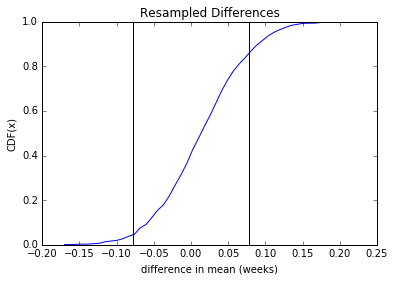

In [4]:
def compute_diff(model1, model2, replace=True):
    sample1 = np.random.choice(model1, size=model1.shape[0], replace=replace)
    sample2 = np.random.choice(model2, size=model2.shape[0], replace=replace)
    return np.mean(sample1) - np.mean(sample2)
    
# Generate 2 random samples with the mean and std of the pooled distributio
pooled_babies = np.array(pregnancies[pregnancies["outcome"] == 1]["prglength"].dropna())
sample_mean = np.mean(pooled_babies)
sample_std = np.std(pooled_babies)
np.random.seed(1)
sample_first = np.random.normal(sample_mean, sample_std, 4413)
sample_other = np.random.normal(sample_mean, sample_std, 4735)

# draw samples from sample_first and sample_other and compute diffs.
# create a distribution of diffs
diffs = np.array([compute_diff(sample_first, sample_other) for x in range(1000)])

diffs_pmf = np.histogram(diffs, bins=50, normed=True)
diffs_cdf_ps = np.cumsum(diffs_pmf[0])
diffs_cdf_ps = diffs_cdf_ps / diffs_cdf_ps[-1]
diffs_cdf_xs = diffs_pmf[1][:-1]

# CDF plot of distribution difference of means
plt.plot(diffs_cdf_xs, diffs_cdf_ps)
plt.axvline(x=-delta, color='k')
plt.axvline(x=delta, color='k')
plt.xlabel("difference in mean (weeks)")
plt.ylabel("CDF(x)")
plt.title("Resampled Differences")

In [5]:
# p-value = fraction of diffs sample where value >= delta
nbr_diffs_ge_delta = np.where(diffs >= delta)[0].shape[0]
print("p-value = %.3f" % (nbr_diffs_ge_delta / diffs.shape[0]))

p-value = 0.172


__Exercise 7.1:__ In the NSFG dataset, the difference in mean weight for first births is 2.0 ounces. Compute the p-value of this difference. 

Hint: for this kind of resampling it is important to sample with replacement, so you should use random.choice rather than random.sample (see Section 3.8).

In [6]:
live_births["birthwgt"] = 16 * live_births["birthwgt_lb"] + live_births["birthwgt_oz"]
pooled = np.array(live_births["birthwgt"].dropna())
first = np.array(live_births[live_births["birthord"] == 1]["birthwgt"].dropna())
other = np.array(live_births[live_births["birthord"] != 1]["birthwgt"].dropna())

/Users/palsujit/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


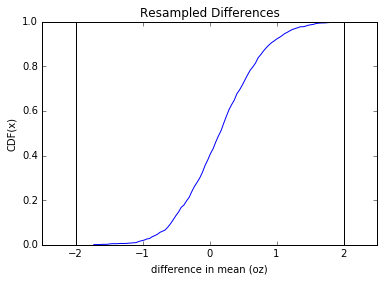

In [7]:
# compute mean and std of pooled data and generate samples of size(first) and size(other)
pooled_mean = np.mean(pooled)
pooled_std = np.std(pooled)
np.random.seed(1)
sample_first = np.random.normal(pooled_mean, pooled_std, first.shape[0])
sample_other = np.random.normal(pooled_mean, pooled_std, other.shape[0])

# create a distribution of diffs by sampling from the above samples many times
diffs = np.array([compute_diff(sample_first, sample_other, True) for x in range(1000)])

# plot the distribution
pmf_diffs = np.histogram(diffs, bins=100, normed=True)
cdf_diffs_ps = np.cumsum(pmf_diffs[0])
cdf_diffs_ps = cdf_diffs_ps / cdf_diffs_ps[-1]
cdf_diffs_xs = pmf_diffs[1][:-1]

plt.plot(cdf_diffs_xs, cdf_diffs_ps)
plt.xlim(-2.5, 2.5)
plt.axvline(x=-2.0, color='k')
plt.axvline(x=2.0, color='k')
plt.xlabel("difference in mean (oz)")
plt.ylabel("CDF(x)")
plt.title("Resampled Differences")

In [8]:
diffs_ge_2 = np.where(diffs >= 2)[0]
print("p-value = %.5f" % (diffs_ge_2.shape[0] / diffs.shape[0]))

p-value = 0.00100


## Choosing a threshold

Common threshold is $\alpha$ = 5%. If the p-value is less than $\alpha$, then difference is statistically significant, else it is not.

So the difference in pregnancy lengths is __not statistically significant__ because 17.2% is greater than 5%, and the difference in birth weights is __statistically significant__ because 1% is less than 5%.

Decreasing $\alpha$ decreases the chance of false positive. But it also raises the standard of evidence, which increases the chance of rejecting a valid hypothesis.

__Exercise 7.2:__ To investigate the effect of sample size on p-value, see what happens if you discard half of the data from the NSFG. Hint: use random.sample. What if you discard three-quarters of the data, and so on? What is the smallest sample size where the difference in mean birth weight is still significant with $\alpha$ = 5%? How much larger does the sample size have to be with $\alpha$ = 1%?

In [9]:
data_keep_fracs = [1.0, 0.5, 0.25, 0.33, 0.1, 0.05, 0.01, 0.005]
spvs = []
for data_keep_frac in data_keep_fracs:
    pool_sample = np.random.choice(pooled, int(pooled.shape[0] * data_keep_frac))
    pool_mean = np.mean(pool_sample)
    pool_std = np.std(pool_sample)
    first_sample = np.random.normal(pool_mean, pool_std, first.shape[0])
    other_sample = np.random.normal(pool_mean, pool_std, other.shape[0])
    diffs = np.array([compute_diff(first_sample, other_sample) for x in range(1000)])
    p_value = np.where(diffs >= 2.0)[0].shape[0] / diffs.shape[0]
    spvs.append((pool_sample.shape[0], p_value))
print("(sample size, p-value):", spvs)

(sample size, p-value): [(9087, 0.0), (4543, 0.0), (2271, 0.0), (2998, 0.004), (908, 0.0), (454, 0.0), (90, 0.005), (45, 0.092)]


## Defining the Effect

__Two sided test__ - check both sides when computing the p-value.

__One sided test__ - check only one side.

For symmetric distributions the two sided p-value should be roughly twice the one-sided value, but in this case, the distribution is skewed right.

In [10]:
p_value_2_sided = np.where((diffs >= 2.0) | (diffs <= -2.0))[0]
p_value_2_sided = p_value_2_sided.shape[0] / diffs.shape[0]
p_value_1_sided = np.where(diffs >= 2.0)[0]
p_value_1_sided = p_value_1_sided.shape[0] / diffs.shape[0]
print("p-value (1 sided): %.3f, (2 sided): %.3f" % (p_value_1_sided, p_value_2_sided))

p-value (1 sided): 0.092, (2 sided): 0.092


## Interpreting the result

We define event E, and compute the p-value, which is P(E|H0) and compare to the threshold $\alpha$.

__Classical:__ if p-value less than $\alpha$, we can conclude effect is __statistically significant__, but can't conclude that its real.

__Practical:__ in practice, people conclude its real. Lower the p-value, the higher the confidence in the conclusion.

__Bayesian:__ what we want to know is:

$$P(H_{A} | E) = \frac {P(E | H_{A}) P(H_{A})} {P(E)}$$

where $H_{A}$ is the alternate hypothesis that the effect is real. Here $P(H_{A})$ is the prior probability of $H_{A}$ before we see the effect, $P(E|H_{A})$ is the probability of seeing the effect assuming it is real, and P(E) is the probability of seeing E under any circumstances. Since the effect is either real or not real, P(E) is given by:

$$P(E) = P(E|H_{A})P(H_{A}) + P(E|H_{0})P(H_{0})$$

__Exercise 7.3:__ Using the NSFG data, what is the posterior probability that the distribution of birth weights is different for first babies than others?

In [11]:
# assume H(A) = first and other distributions are different and the difference is 2.0
# compute P(E|HA)
np.random.seed(1)
first_sample = np.random.normal(pool_mean, pool_std, first.shape[0])
other_sample = np.random.normal(pool_mean, pool_std, other.shape[0])
diffs = np.array([compute_diff(first_sample, other_sample) for x in range(1000)])
diffs_ge_2 = np.where(diffs >= 2.0)
p_e_ha = diffs_ge_2[0].shape[0] / diffs.shape[0]
# prior P(HA) = P(H0) = 0.5 since we assume no knowledge
p_ha = 0.5
p_h0 = 0.5
# we already know H(E|H0) = 0.001 from before 
p_e_h0 = 0.001
p_ha_e = p_e_ha * p_ha / (p_e_ha * p_ha + p_e_h0 * p_h0)
print("posterior probability that birth weights are different: %.3f" % (p_ha_e))

posterior probability that birth weights are different: 0.875


## Cross-validation

Split the data into training and test OR partition and run over each partition, then average. Second method shown.

In [12]:
p_ha = 0.5
p_h0 = 0.5
p_e_h0 = 0.001
post_probs = []
np.random.seed(1)
for i in range(10):
    idxs = np.random.choice(pooled, size=8000)
    pool_split = pooled[np.array(idxs, dtype=int)]
    pool_mean = np.mean(pool_split)
    pool_std = np.mean(pool_split)
    first_sample = np.random.normal(pool_mean, pool_std, first.shape[0])
    other_sample = np.random.normal(pool_mean, pool_std, other.shape[0])
    diffs = np.array([compute_diff(first_sample, other_sample) for x in range(1000)])
    diffs_ge_2 = np.where(diffs >= 2.0)
    p_e_ha = diffs_ge_2[0].shape[0] / diffs.shape[0]
    post_probs.append(p_e_ha * p_ha / (p_e_ha * p_ha + p_e_h0 * p_h0))
print("posterior probability (averaged) = %.3f" % (sum(post_probs) / len(post_probs)))

posterior probability (averaged) = 0.985


## Reporting Bayesian Probabilities

__Objection to Bayesian probabilities:__ arbitary priors. However, strong evidence will swamp the prior.

__Likelihood Ratio:__ also called __Bayes Factor__.

$$likelihood \space ratio = \frac {P(E|H_{A})}{P(E|H_{0})}$$

__Exercise 7.4:__ If your prior probability for a hypothesis, HA, is 0.3 and new evidence becomes available that yields a likelihood ratio of 3 relative to the null hypothesis, H0, what is your posterior probability for HA?

You can use Bayes theorem and the formula for LR to find that P(HA|E) = (9/7)P(H0|E). But P(HA|E) + P(H0|E) = 1, so P(HA|E) = 9/16.

__Exercise 7.5:__ Two people have left traces of their own blood at the scene of a crime. A suspect, Oliver, is tested and found to have type O blood. The blood groups of the two traces are found to be of type O (a common type in the local population, having frequency 60%) and of type AB (a rare type, with frequency 1%). Do these data (the blood types found at the scene) give evidence in favor of the proposition that Oliver was one of the two people whose blood was found at the scene?

Covered in [Allen Downey's blog post](http://allendowney.blogspot.com/2011/10/all-your-bayes-are-belong-to-us.html).

    H0 = Oliver is not one of the people
    H1 = Oliver is one of the people
    E = 2 blood samples found

    P(E|H0) = 2 samples * (0.6 * 0.01) = 0.12
    P(E|H1) = 0.01 (since Oliver already has O, we just need the other guy with AB)
    LR = P(E|H1) / P(E|H0) = 1/12

## Chi-square test

Instead of testing whether the apparent difference in mean pregnancy length is significant or not, alternative is to test the hypothesis as it appears - ie, first babies are more likely to be early, less likely to be on time and more likely to be late.

Formula for chi-squared ratio is:

$$\chi^{2} = \sum_{i} \frac {(O_{i} - E_{i})^{2}}{E_{i}}$$

H0 = pregnancy length distribution is the same for both groups. The p-value is the probability of seeing a chi-squared value as high as the one observed.

observed chi-squared value: 92.12957073


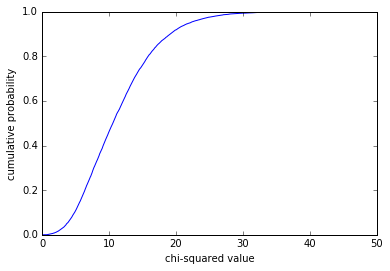

In [13]:
# (1) Find observed values and partition into 6 cells
#              |early  | on-time | late
# -------------+-------+---------+------
# first babies |       |         |
# others       |       |         |
observed = np.zeros(6)
observed[0] = len(live_births[(live_births["birthord"] == 1) & 
                              (live_births["prglength"] <= 37)]["prglength"].dropna())
observed[1] = len(live_births[(live_births["birthord"] == 1) & 
                              ((live_births["prglength"] == 38) |
                               (live_births["prglength"] == 39) |
                               (live_births["prglength"] == 40))]["prglength"].dropna())
observed[2] = len(live_births[(live_births["birthord"] == 1) & 
                              (live_births["prglength"] >= 41)]["prglength"].dropna())
observed[3] = len(live_births[(live_births["birthord"] != 1) & 
                              (live_births["prglength"] <= 37)]["prglength"].dropna())
observed[4] = len(live_births[(live_births["birthord"] != 1) & 
                              ((live_births["prglength"] == 38) |
                               (live_births["prglength"] == 39) |
                               (live_births["prglength"] == 40))]["prglength"].dropna())
observed[5] = len(live_births[(live_births["birthord"] != 1) & 
                              (live_births["prglength"] >= 41)]["prglength"].dropna())
                              
# (2) compute expected values for each cell. H0 says distributions are 
#     same, so we use pooled probabilities P(early), P(ontime), P(late)
#     Actual expected numbers are n*P(...) for first and m*P(...) for other
nbr_first_babies = len(live_births[live_births["birthord"] == 1].dropna())
nbr_other_babies = len(live_births[live_births["birthord"] != 1].dropna())
nbr_pooled = nbr_first_babies + nbr_other_babies
nbr_early_pooled = len(live_births[live_births["prglength"] <= 37])
nbr_ontime_pooled = len(live_births[(live_births["prglength"] == 38) | 
                                    (live_births["prglength"] == 39) | 
                                    (live_births["prglength"] == 40)].dropna())
nbr_late_pooled = len(live_births[live_births["prglength"] >= 41].dropna())
expected = np.zeros(6)
expected[0] = nbr_first_babies * nbr_early_pooled / nbr_pooled
expected[1] = nbr_first_babies * nbr_ontime_pooled / nbr_pooled
expected[2] = nbr_first_babies * nbr_late_pooled / nbr_pooled
expected[3] = nbr_other_babies * nbr_early_pooled / nbr_pooled
expected[4] = nbr_other_babies * nbr_ontime_pooled / nbr_pooled
expected[5] = nbr_other_babies * nbr_late_pooled / nbr_pooled

# (3) compute deviation, ie, difference between observed and expected
# (4) compute chi-squared statistic
deviation = np.power(observed - expected, 2) / expected
chi2 = np.sum(deviation)
print("observed chi-squared value:", chi2)

# (5) use Monte Carlo simulation to compute p-value, ie the probability of
#     seeing a chi-squared value as high as that observed under H0.
pool_data = np.array(live_births["prglength"].dropna())
pool_mean = np.mean(pool_data)
pool_std = np.std(pool_data)
first_data = np.array(live_births[live_births["birthord"] == 1]["prglength"].dropna())
first_mean = np.mean(first_data)
first_std = np.std(first_data)
other_data = np.array(live_births[live_births["birthord"] != 1]["prglength"].dropna())
other_mean = np.mean(other_data)
other_std = np.std(other_data)
np.random.seed(1)
sample_chi2s = []
for i in range(10000):
    pool_sample = np.random.normal(pool_mean, pool_std, nbr_pooled)
    first_sample = np.random.normal(first_mean, first_std, nbr_first_babies)
    other_sample = np.random.normal(other_mean, other_std, nbr_other_babies)
    # compute sample observed
    sample_obs = np.zeros(6)
    sample_obs[0] = np.where(first_sample <= 37)[0].shape[0]
    sample_obs[1] = np.where((first_sample == 38) | 
                             (first_sample == 39) | 
                             (first_sample == 40))[0].shape[0]
    sample_obs[2] = np.where(first_sample >= 41)[0].shape[0]
    sample_obs[3] = np.where(other_sample <= 37)[0].shape[0]
    sample_obs[4] = np.where((other_sample == 38) | 
                             (other_sample == 39) | 
                             (other_sample == 40))[0].shape[0]
    sample_obs[5] = np.where(other_sample >= 41)[0].shape[0]
    # compute sample expected
    sample_pool_early = np.where(pool_sample <= 37)[0].shape[0]
    sample_pool_ontime = np.where((pool_sample == 38) | 
                                  (pool_sample == 39) | 
                                  (pool_sample == 40))[0].shape[0]
    sample_pool_late = np.where(pool_sample >= 41)[0].shape[0]
    sample_exp = np.zeros(6)
    sample_exp[0] = nbr_first_babies * sample_pool_early / nbr_pooled
    sample_exp[1] = nbr_first_babies * sample_pool_ontime / nbr_pooled
    sample_exp[2] = nbr_first_babies * sample_pool_late / nbr_pooled
    sample_exp[3] = nbr_other_babies * sample_pool_early / nbr_pooled
    sample_exp[4] = nbr_other_babies * sample_pool_ontime / nbr_pooled
    sample_exp[5] = nbr_other_babies * sample_pool_late / nbr_pooled
    # compute chi-squared, denom has a slight delta added for divide-by-zero
    sample_dev = np.power(sample_obs - sample_exp, 2) / (sample_exp + 1e-9)
    sample_chi2s.append(np.sum(sample_dev))

pmf_chi2 = np.histogram(np.array(sample_chi2s), bins=1000, normed=True)
cdf_chi2_ps = np.cumsum(pmf_chi2[0])
cdf_chi2_ps = cdf_chi2_ps / cdf_chi2_ps[-1]
cdf_chi2_xs = pmf_chi2[1][:-1]

plt.plot(cdf_chi2_xs, cdf_chi2_ps)
plt.xlabel("chi-squared value")
plt.ylabel("cumulative probability")

In [14]:
p_value_idx = np.where(cdf_chi2_xs > chi2)[0]
p_value = 0 if len(p_value_idx) == 0 else cdf_chi2_xs[p_value_idx]
stat_sig = ""
if p_value < 0.01:
    stat_sig = "stat sig @ 99%"
elif p_value < 0.05:
    stat_sig = "stat sig @ 95%"
else:
    stat_sig = "not stat sig"
print("p-value: %.3f (%s)" % (p_value, stat_sig))

p-value: 0.000 (stat sig @ 99%)


__Exercise 7.6:__ Suppose you run a casino and you suspect that a customer has replaced a die provided by the casino with a “crooked die;” that is, one that has been tampered with to make one of the faces more likely to come up than the others. You apprehend the alleged cheater and confiscate the die, but now you have to prove that it is crooked.

You roll the die 60 times and get the following results: (1, 8), (2, 9), (3, 19), (4, 6), (5, 8), (6, 10). 

What is the chi-squared statistic for these values? What is the probability of seeing a chi-squared value as large by chance?

In [15]:
# compute the chi-squared value from the observed data
observed = np.array([8, 9, 19, 6, 8, 10])
expected = np.array([10, 10, 10, 10, 10, 10])  # each face equally likely
observed_chi2 = np.sum(np.power(observed - expected, 2) / expected)
print("observed chi-squared value: %.3f" % (observed_chi2))

# compute a distribution of chi-squared values by sampling
def sample_by_cdf(cdf_xs, cdf_ps, n):
    """ Create a sample based on a CDF """
    samples = []
    for i in range(n):
        prob = np.random.random()
        for j in range(cdf_ps.shape[0]):
            if cdf_ps[j] > prob:
                break
        samples.append(cdf_xs[j])
    return samples

pmf_obs = observed / 60
cdf_obs_ps = np.cumsum(pmf_obs)
cdf_obs_xs = np.array([1, 2, 3, 4, 5, 6])
sample_chi2s = np.zeros(1000)
for i in range(1000):
    sample_obs = sample_by_cdf(cdf_obs_xs, cdf_obs_ps, 1000)
    sample_exp = np.random.uniform(low=1, high=6, size=1000)
    sample_chi2s[i] = np.sum(np.power(sample_obs - sample_exp, 2) / sample_exp)
    
# compute the CDF for the chi-squared values distribution
pmf_chi2 = np.histogram(sample_chi2s, bins=1000, normed=True)
cdf_chi2_ps = np.cumsum(pmf_chi2[0])
cdf_chi2_ps = cdf_chi2_ps / cdf_chi2_ps[-1]
cdf_chi2_xs = pmf_chi2[1][:-1]

# compute p-value = prob(seeing a chi-squared value high as that observed)
p_value_idx = np.where(cdf_chi2_xs >= observed_chi2)[0][0]
p_value = cdf_chi2_ps[p_value_idx]
statsig = ""
if p_value < 0.01:
    statsig = "stat sig @ 99%"
elif p_value < 0.05:
    statsig = "stat sig @ 95%"
else:
    statsig = "not stat sig"
print("p-value: %.3f (%s)" % (p_value, statsig))

observed chi-squared value: 10.600
p-value: 0.001 (stat sig @ 99%)


## Efficient Resampling

In the __Testing Difference in Means__ problem above, we can also use the formulas for normal distribution to reduce some of the work.

We have n=4413 first babies and m=4735 other babies. Our H0 is that they are from the same distribution. So if $\mu$ and $\sigma$ are the mean and standard deviation for the pooled distribution, then a sample mean from the first baby distribution is $\mathcal{N}(\mu, \frac {\sigma^2}{n})$ and one from the other baby distribution is $\mathcal{N}(\mu, \frac {\sigma^2}{m})$. Using the formula for the difference of means:

$$X - Y \sim \mathcal{N}(\mu_{X}-\mu_{Y}, \sigma_{X}^2+\sigma_{Y}^2) \sim \mathcal{N}(0, (\frac{1}{m}+\frac{1}{n})\sigma^{2})$$

In [16]:
diff_dist = scipy.stats.norm(loc=0, 
                             scale=math.sqrt(((1 / 4413) + (1 / 4735)) * 
                             math.pow(pool_std, 2)))
left = diff_dist.cdf(-0.078)
right = 1 - diff_dist.cdf(0.078)
print("p-value (evidence for H0): %.3f" % (left + right))

p-value (evidence for H0): 0.168


## Power

Negative hypothesis test does not necessarily imply effect is not real. Depends on __power__ of test, defined as the probability that the test will be positive if the null hypothesis is false. In general, the power of a test depends on the sample size, the magnitude of the effect, and the threshold $\alpha$.

Interesting tool for [Statistical Power Analysis](https://amarder.github.io/power-analysis/).

__Exercise 7.7:__ What is the power of the test above using $\alpha$ = 0.05 and assuming that the actual difference between the means is 0.078 weeks? You can estimate power by generating random samples from distributions with the given difference in the mean, testing the observed difference in the mean, and counting the number of positive tests.

What is the power of the test with $\alpha$ = 0.10?

In [17]:
# assume H0 = both distributions are identical. So from above
nbr_pos_at_5 = 0
nbr_pos_at_1 = 0
for i in range(1000):
    diff_std = math.sqrt(((1 / 4413) + (1 / 4735)) * math.pow(pool_std, 2))
    # generate a diff sample
    diff_sample = np.random.normal(0, diff_std, 1000)
    # calculate PMF and CDF
    pmf_diff = np.histogram(diff_sample, bins=100, normed=True)
    cdf_diff_ps = np.cumsum(pmf_diff[0])
    cdf_diff_ps = cdf_diff_ps / cdf_diff_ps[-1]
    cdf_diff_xs = pmf_diff[1][:-1]
    # calculate p-value
    left = np.where(cdf_diff_xs <= -0.078)[0][0]
    right = np.where(cdf_diff_xs >= 0.078)[0][0]
    p_left = cdf_diff_ps[left]
    p_right = 1.0 - cdf_diff_ps[right]
    p_value = p_left + p_right
    # null hypothesis is false if p-value < alpha
    # test is positive if null hypothesis is false
    if p_value < 0.05:
        nbr_pos_at_5 += 1
    if p_value < 0.1:
        nbr_pos_at_1 += 1
print("power with alpha 0.05 = %.3f" % (nbr_pos_at_5 / 1000))
print("power with alpha 0.1 = %.3f" % (nbr_pos_at_1 / 1000))
# so null hypothesis is false at both levels, and there is a difference

power with alpha 0.05 = 0.008
power with alpha 0.1 = 0.998
